# External Stability (Pay-off Biased)

In [147]:
import numpy as np
#import importlib
from numpy import linalg
import PO_helperfuns
from PO_helperfuns import *
import PO_DatFrameFuns
from PO_DatFrameFuns import *
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
#importlib.reload(helperfuns)
import pandas as pd
#import sympy as sp
from sympy import *
#from sympy.solvers import solve
#np.set_printoptions(precision=3, suppress = True)
#import seaborn as sns
# next two libraries are used to flatten list of lists
import functools
import operator

# for ternary plots
import ternary


# for formatting tick labels
#from matplotlib.ticker import FormatStrFormatter

#for parallelizing:
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

# display options so complex numbers look ok
pd.options.display.float_format = lambda x: '{:0.4f}'.format(np.real(x)) if np.imag(x)==0 else "{0.real:.4}+{0.imag:.4}j".format(x)

## Bifurcation diagram for external stability

In [148]:

def ExternalStability(beta, s,mu):
    # find K and pc
    norm = scs.norm(mu)
    K = Kfun(s,norm)
    pc = pcfun(s,norm)
    u1 = PredictEquilibrium_NoPref(K,pc, beta)
    r1 = 1 - beta*u1
    W = 1 + pc + 2*r1*(K/2 + pc)
    fs = norm.pdf(s)
    fminuss = norm.pdf(-s)
    grad_s = (-fs*(1+r1) + r1*fminuss)/W
    moreSoc = grad_s > 0
    lessSoc = (grad_s<0) & (s>0)
    stable = np.array(grad_s==0,dtype = int) + np.array((grad_s<0) & (s==0), dtype=int)
    stability = np.zeros(grad_s.shape)
    stability[moreSoc] = 1
    stability[lessSoc] = 0
    stability[stable>0] = -1
    return(grad_s,stability)

def InsideContour(beta,s,mu):
    grad_s, stability = ExternalStability(beta,s,mu)
    stability = np.array(stability, dtype = int)
    str0 = r'$C_s = 0$, ' + 'Social Learning \nStable'
    str1 = r'$C_s < 0$, ' + '\nLess Social \nLearning Invades'
    str2 = r'$C_s > 0$, ' + '\nMore Social \nLearning Invades'
    dic = {-1:str0, 0:str1, 1:str2}
    return(grad_s, stability, dic)
def Add_Labels_ColorBar(fig,dic=None, labels=None):
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
    cb = fig.colorbar(cp, cax = cbar_ax)
    
    if labels != None: # i.e. labels a
        if dic!= None:
            cb.ax.get_yaxis().set_ticks(labels)
            cb.ax.set_yticklabels([dic[t] for t in labels])
        else:
            cb.ax.set_yticklabels(labels)
    else:
        cb.ax.set_title(r'$C_s$',fontsize=20, pad = 15)
    
    cb.ax.get_yaxis().labelpad = 15
    labels = cb.ax.yaxis.get_ticklabels()
    [l.set_fontsize(18) for l in labels]
    fig.subplots_adjust(hspace=0.25,wspace = 0.25)
    # add axis labels
    fig.text(0.1,0.92, 'A)', fontsize = 24, fontweight='bold',va='top', ha='right')
    fig.text(0.47,0.92,'B)',fontsize = 24, fontweight='bold',va='top', ha='right')
    fig.text(0.1,0.5,'C)',fontsize = 24, fontweight='bold',va='top', ha='right')
    fig.text(0.47,0.5,'D)',fontsize = 24, fontweight='bold',va='top', ha='right')
    return(fig)
    

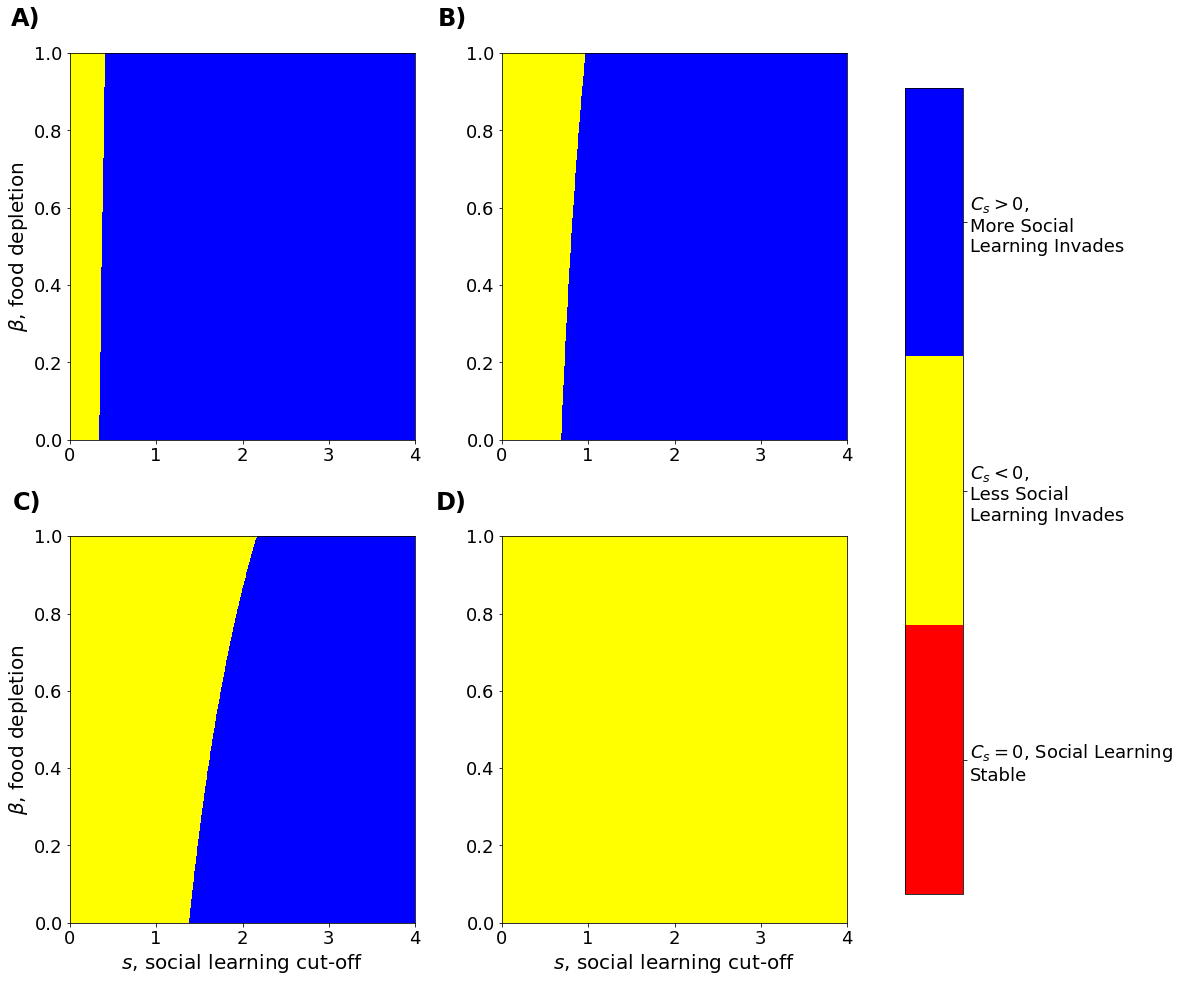

In [152]:
# fig, axes for just looking at stability
fig1, axes1 = plt.subplots(2,2,figsize = (16,16))


# make meshes
muvals = [-1,-0.5,-0.25,0]
betavals = np.linspace(0,1,250)
svals = np.linspace(0,4,800)
Bmesh,Smesh = np.meshgrid(betavals,svals)

classify_matvec = [0,0,0,0]
grads_matvec = [0,0,0,0]
# plot stability figure but store grad_s

for i,ax in enumerate(axes1.flatten()):
    grad_s, stability, dic = InsideContour(Bmesh,Smesh,muvals[i])
    classify_matvec[i] = stability;
    cp = ax.contourf(Smesh,Bmesh,stability , levels = [-1.5,-0.5, 0.5,1.5], colors = ['red','yellow','blue'])
    ax.tick_params(axis='both', which='major', labelsize=18)
    if i == 0 or i == 2:
        ax.set_ylabel(r'$\beta$'+", food depletion", fontsize = 20)
    if i > 1:
        ax.set_xlabel(r'$s$'+", social learning cut-off", fontsize = 20)
        

#for i, lab in enumerate(["real,\nstable", "complex, \nstable", "complex, \nunstable"]):
#    cb.ax.text(2.5, (3 * i ) / 3.0 -0.5, lab,  va='center', fontsize=18)
fig1 = Add_Labels_ColorBar(fig1,dic=dic, labels=[-1,0,1])

fig1.savefig('Figures/PO_ExternalStabilityContour_lowMu.png')

In [ ]:
min = 

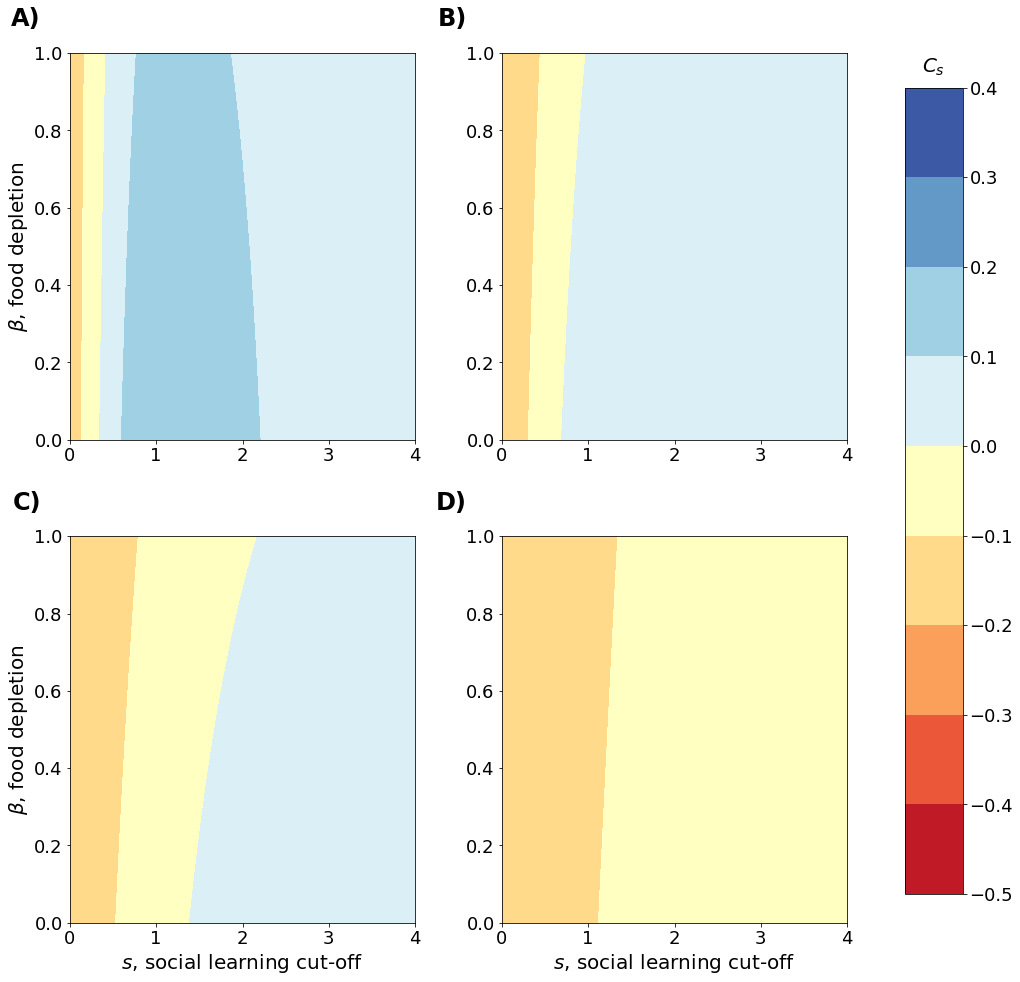

In [197]:
# fig, axes for values of eigenvalues
fig, axes = plt.subplots(2,2,figsize=(16,16))

# make meshes
muvals = [-1,-0.5, -0.25,0]
betavals = np.linspace(0,1,300)
svals = np.linspace(0,4,800)
Bmesh,Smesh = np.meshgrid(betavals,svals)

for i,ax in enumerate(axes.flatten()):
    grad_s, stability, dic = InsideContour(Bmesh,Smesh,muvals[i])
    cp = ax.contourf(Smesh,Bmesh,grad_s, levels = np.arange(-0.5,0.5,0.1), cmap = "RdYlBu")
    ax.tick_params(axis='both', which='major', labelsize=18)
    if i == 0 or i == 2:
        ax.set_ylabel(r'$\beta$'+", food depletion", fontsize = 20)
    if i > 1:
        ax.set_xlabel(r'$s$'+", social learning cut-off", fontsize = 20)
fig = Add_Labels_ColorBar(fig,dic=None, labels=None)
fig.savefig('Figures/PO_Grad_sContour_lowMu.png')
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
#cb = fig.colorbar(cp, cax = cbar_ax)
#fig2 = Add_Labels_ColorBar(fig2)

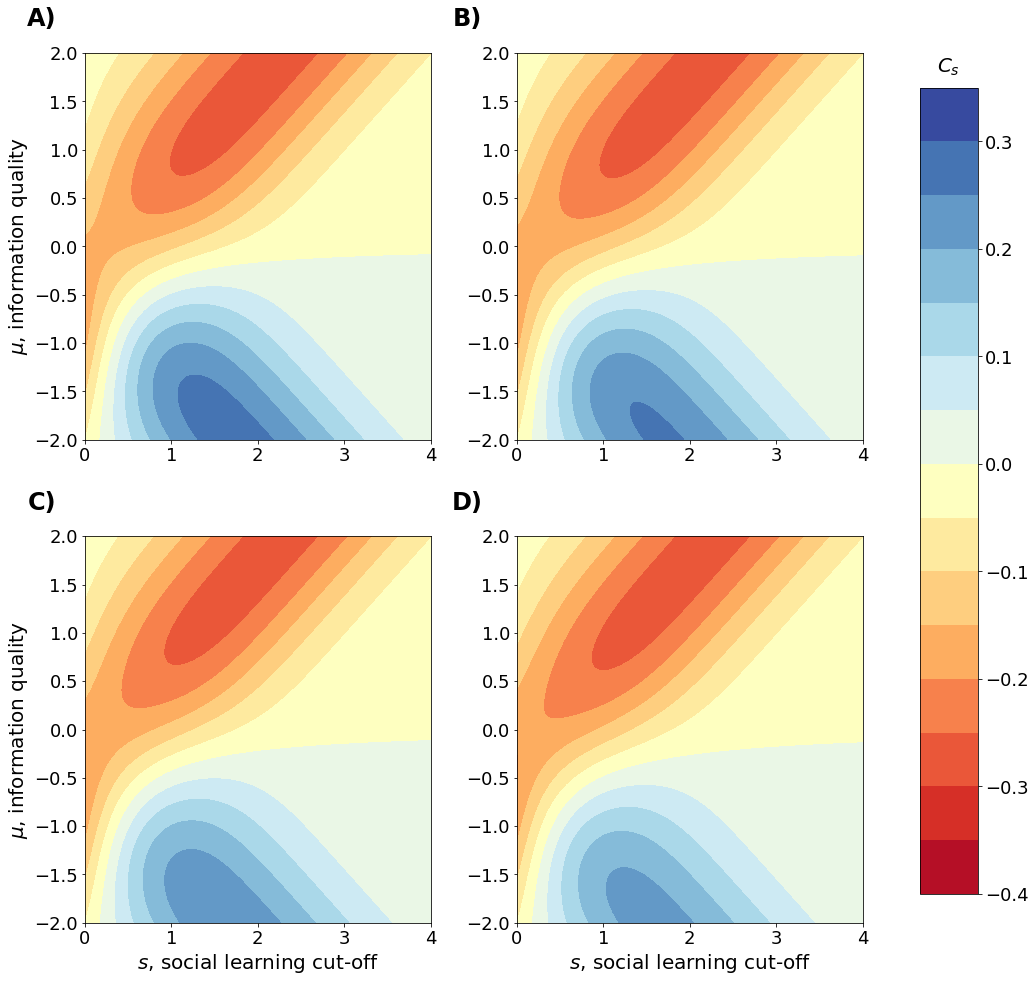

In [156]:
# fig, axes for values of eigenvalues
fig, axes = plt.subplots(2,2,figsize=(16,16))

# make meshes
betavals = [0,float(1)/3,float(2)/3,1]
muvals = np.linspace(-2,2,400)
svals = np.linspace(0,4,800)
mumesh,Smesh = np.meshgrid(muvals,svals)

for i,ax in enumerate(axes.flatten()):
    beta = betavals[i]
    grad_s, stability, dic = InsideContour(beta,Smesh,mumesh)
    cp = ax.contourf(Smesh,mumesh,grad_s, levels = np.arange(-0.4,0.4,0.05), cmap = "RdYlBu")
    ax.tick_params(axis='both', which='major', labelsize=18)
    if i == 0 or i == 2:
        ax.set_ylabel(r'$\mu$'+", information quality", fontsize = 20)
    if i > 1:
        ax.set_xlabel(r'$s$'+", social learning cut-off", fontsize = 20)
fig = Add_Labels_ColorBar(fig,dic=None, labels=None)
fig.savefig('Figures/PO_mu_Grad_sContour.png')
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
#cb = fig.colorbar(cp, cax = cbar_ax)
#fig2 = Add_Labels_ColorBar(fig2)

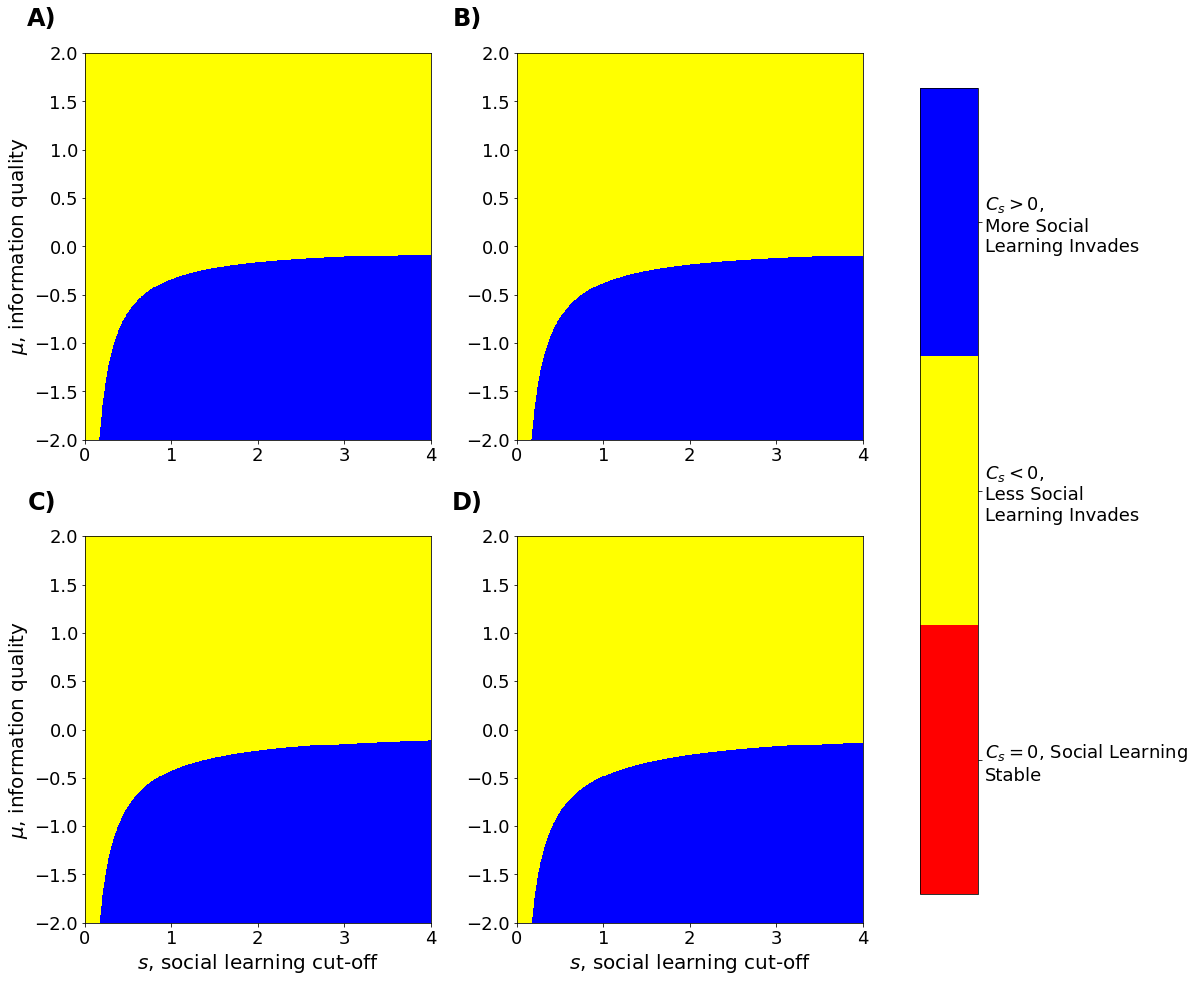

In [192]:
# fig, axes for just looking at stability
fig1, axes1 = plt.subplots(2,2,figsize = (16,16))


# make meshes
betavals = [0,float(1)/3,float(2)/3,1]
muvals = np.linspace(-2,2,400)
svals = np.linspace(0,4,800)
mumesh,Smesh = np.meshgrid(muvals,svals)

classify_matvec = [0,0,0,0]
grads_matvec = [0,0,0,0]
# plot stability figure but store grad_s

for i,ax in enumerate(axes1.flatten()):
    grad_s, stability, dic = InsideContour(betavals[i],Smesh,mumesh)
    classify_matvec[i] = stability;
    cp = ax.contourf(Smesh,mumesh,stability , levels = [-1.5,-0.5, 0.5,1.5], colors = ['red','yellow','blue'])
    ax.tick_params(axis='both', which='major', labelsize=18)
    if i == 0 or i == 2:
        ax.set_ylabel(r'$\mu$'+", information quality", fontsize = 20)
    if i > 1:
        ax.set_xlabel(r'$s$'+", social learning cut-off", fontsize = 20)
        

#for i, lab in enumerate(["real,\nstable", "complex, \nstable", "complex, \nunstable"]):
#    cb.ax.text(2.5, (3 * i ) / 3.0 -0.5, lab,  va='center', fontsize=18)
fig1 = Add_Labels_ColorBar(fig1,dic=dic, labels=[-1,0,1])

#fig1.savefig('Figures/PO_ExternalStabilityContour_lowMu.png')

## Trajectories after invasion

In [138]:
# makes the first points in the trajectory
def get_init_pts(mu,s,beta):
    # Learning parameters
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    
    # get uvec, rvec
    u1 = PredictEquilibrium_NoPref(K,pc,beta)
    r1 = 1 - beta*u1
    uvec = [u1,u1,1-2*u1]
    rvec = [r1,r1]
    
    # get perturbations
    perturbations = Perturb(uvec,rvec)
    dumat, xinitmat, drmat = perturbations
    
    
    u1init = u1 + dumat[:,0]
    u2init = u1+dumat[:,1]
    buinit = 1-2*u1 + dumat[:,2]
    r1init = r1 + drmat[:,0]
    r2init = r1 + drmat[:,1]
    
    
    init_pts = pd.DataFrame({'mu':mu,'K': K, 'pc': pc,'s':s, 'beta': beta, 'u1': u1init, 'u2':u2init, 
            'bu':buinit, 'r1':r1init, 'r2':r2init, 'x1':xinitmat[:,0],'x2':xinitmat[:,1],
                            'bx':xinitmat[:,2]})
    u1eq = PredictEquilibrium_NoPref(K,pc,beta)
    init_pts['u1eq'] = u1
    init_pts['u2eq'] = u1
    init_pts['bueq'] = 1 - 2*u1
    init_pts['r1eq'] = 1 - beta*u1
    init_pts['r2eq'] = 1 - beta*u1
    init_pts['W'] = 1 + pc + 2*r1*(K/2 + pc)
    return(u1eq, init_pts)


"""
Perturb

Finds valid perturbations for a set of equilibria (i.e. perturbations that won't result in invalid frequencies)
---
Parameters
    row
---
Returns
    list of perturbations in the u -direction, the z direction (stand-in for x or y... i know it's confusing),
and the r direction
"""
def Perturb(uvec,rvec):
    
    # get new post-perturb vectors
    du = 0.01
    duvec_1 = -du*np.array([0.015, 0.11, 1 - 0.015 - 0.11])
    duvec_2 = -du*np.array([0.29, 0.49, 1 - 0.29 - 0.49])
    duvec_3 = -du*np.array([0.49, 0.51, 1 - 0.51 - 0.49])
    duvec_4 = -du*np.array([0.9,0.05, 0.05])
    duvec_list = [Perturb_EdgeCase(uvec,duvec) for duvec in [duvec_1, duvec_2,
                                                                duvec_3, duvec_4]]
    duvec_list = np.array(duvec_list)
    
    dx = 0.01
    new_x_1 = dx*np.array([0.05,0.1, 1 - 0.05 - 0.1])
    new_x_2 = dx*np.array([0.48, 0.5, 1 - 0.48 - 0.5])
    new_x_3 = dx*np.array([0.9, 0.04, 0.06])
    new_x_4 = dx*np.array([0.3,0.6,1 - 0.9])
    
    xinit_list = np.array([new_x_1, new_x_2, new_x_3, new_x_4])
    
    dr = 0.01
    drvec_1 = dr*np.array([1,0.9])
    drvec_2 = dr*np.array([0.5,-0.3])
    drvec_3 = dr*np.array([-1,0.99])
    drvec_4 = dr*np.array([-0.2, -0.8])
    drvec_list = [Perturb_EdgeCase_r(rvec, drvec) for drvec in [drvec_1,drvec_2,
                                                                 drvec_3, drvec_4]]
    drvec_list = np.array(drvec_list)
    
    return(duvec_list,xinit_list,drvec_list)

"""
Perturb_EdgeCase

    Adjusts the direction of a perturbation to account for cases where u_1 = 0, u_2 = 0, or bu = 0
    ---
    Parameters
        uvec - 3-vector (np.array) of the equilibrium u1, u2, bu values
        duvec - 3-vector (np.array) of delta_(u_1), delta_(u_2), delta_(ubar)
    ---
    Returns
        duvec - the original duvec adjusted so we do not perturb u1, u2, bu over a boundary
"""
def Perturb_EdgeCase(uvec,duvec):
    #recursively checks for edge cases so i don't get an invalid frequency. Adjusts duvec if needed
    
    # make sure using numpy arrays
    du = sum(duvec)
    uvec = np.array(uvec); duvec = np.array(duvec);
    # find locations of edge cases
    edge_bool = uvec + duvec <= 0
    
    n = sum(edge_bool)
    if n>0:
        duvec[edge_bool] = -uvec[edge_bool] +0.00001 # so not at exactly 0
        du_remain = du - sum(duvec)
        duvec[~edge_bool] = duvec[~edge_bool] + (1/np.float64(3-n))*du_remain
        
        # make sure that we didn't cause a different frequency to be negative:
        return(Perturb_EdgeCase(uvec,duvec))

    else:
        return(duvec)
"""
Perturb_EdgeCase

    Adjusts the direction of a perturbation to account for cases where r_i = 0 or 1
    ---
    Parameters
        rvec - 2-vector of the equilibrium r1, r2 values
        drvec - 2-vector of delta_(r_1), delta_(r_2)
    ---
    Returns
        drvec - the original drvec adjusted so we do not perturb r1, r2 over a boundary
"""
def Perturb_EdgeCase_r(rvec,drvec):
    #recursively checks for edge cases so i don't get an invalid frequency. Adjusts duvec if needed
    
    # make sure using numpy arrays
    rvec = np.array(rvec); drvec = np.array(drvec);
    # find locations of edge cases
    edge_bool_0 = rvec + drvec <= 0 
    edge_bool_1 = rvec + drvec >= 1
    edge_bool = edge_bool_0 + edge_bool_1
    drvec[edge_bool] = -drvec[edge_bool] # just change the direction of the perturbation
    return(drvec)



# inputs: u1eq, row created by get_init_pts, and max number of steps to run iteration
def get_trajectory_external(row,ds=0.01,tsteps = 1000):

    mu,s,K,pc,beta, u1, u2, bu, x1,x2,bx, r1, r2,W,color = np.transpose(*row[['mu','s','K','pc','beta', 'u1','u2',
                                                       'bu', 'x1','x2','bx','r1','r2','W','color']].values)

    
    # calculate dk and d_(pi_C)
    norm = scs.norm(mu,1)
    dk = Kfun(s + ds, norm) - K
    dpc = pcfun(s + ds, norm) - pc
    
    uvec = [u1,u2,bu]; xvec = [x1,x2,bx]; rvec = [r1,r2]
    list_rows = []
    
    for t in range(0,tsteps):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2], 
                                 "x1":xvec[0], "x2": xvec[1], "bx": xvec[2],
                                 "r1":rvec[0], "r2": rvec[1], "W": W,
                                 "tstep":t, "color":color, "ds":ds},
                                index=[t])
        list_rows.append(curr_row)
        curr_pt = np.transpose(*curr_row[['u1','u2','bu','x1','x2','bx','r1','r2']].values)
        if t>1:
            if np.allclose(curr_pt, old_pt,rtol = 1e-10, atol = 1e-10):
                break
        uvec,xvec,rvec,W = NextGen(uvec,xvec,rvec,K,pc,beta, deltas=[dk, dpc])
        old_pt =  curr_pt
            
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df.sort_values(by=['tstep']))
'''
plot_trajectories: plots u1, x1, r1 trajectories
'''
def plot_trajectories(mu,s,beta, ds,tsteps=10, detail_plot_loc = 0, colors = ['r','c','m','k']):
    u1eq, init_pts = get_init_pts(mu,s,beta)
    init_pts['color'] = colors
    
    fig, axes = plt.subplots(1,3,figsize = (15,5),sharex=True)
    
#     nrow = 4 #len(init_pts)
#     row_list = np.array_split(init_pts,nrow)
    
    # parallelize
    cores = 4
    df_split = np.array_split(init_pts, cores, axis=0)
    pool = Pool(cores)
    wrapperfun = lambda x: get_trajectory_external(x,ds=ds,tsteps=tsteps)
    traj_df_list = pool.map(wrapperfun, df_split)
    pool.close()
    pool.join()
    pool.clear()
    
#     traj_df_list = [get_trajectory_external(row,ds = ds, tsteps = tsteps) for row in row_list]
    
    for i, traj_df in enumerate(traj_df_list):
        label = "Trajectory %d"%i
        if tsteps < 100:
            marker = 'o'
        else:
            marker=''
        axes[0].plot(traj_df.tstep, traj_df.u1, color = colors[i], label = label, marker=marker)
        axes[1].plot(traj_df.tstep, traj_df.x1, color = colors[i], label = label, marker=marker)
        axes[2].plot(traj_df.tstep, traj_df.r1, color = colors[i], label = label,marker=marker)
    
    # put u1eq, r1eq
    axes[0].scatter(0,u1eq, marker='*',s=200,color = 'orange')
    axes[2].scatter(0,1-beta*u1eq, marker='*',s=200,color = 'orange')
    
    # set titles
    axes[0].set_title(r'$u_1$ trajectory', fontsize = 20)
    axes[1].set_title(r'$x_1$ trajectory', fontsize = 20)
    axes[2].set_title(r'$r_1$ trajectory', fontsize = 20)
    
    #set y labels
    axes[0].set_ylabel(r'$u_1$', fontsize = 20)
    axes[1].set_ylabel(r'$x_1$', fontsize = 20)
    axes[2].set_ylabel(r'$r_1$', fontsize = 20)
    
    # set x labels... doing each individually because the shared one looks weird
    axes[0].set_xlabel('time steps', fontsize = 20)
    axes[1].set_xlabel('time steps', fontsize = 20)
    axes[2].set_xlabel('time steps', fontsize = 20)
    
    fig.tight_layout(w_pad=2)
    return(fig)
    #fig.supxlabel('time steps', fontsize = 20)
    # set xlabels

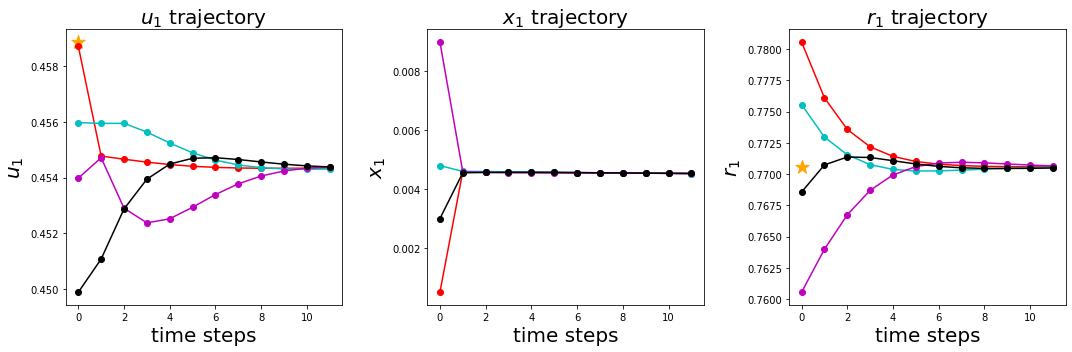

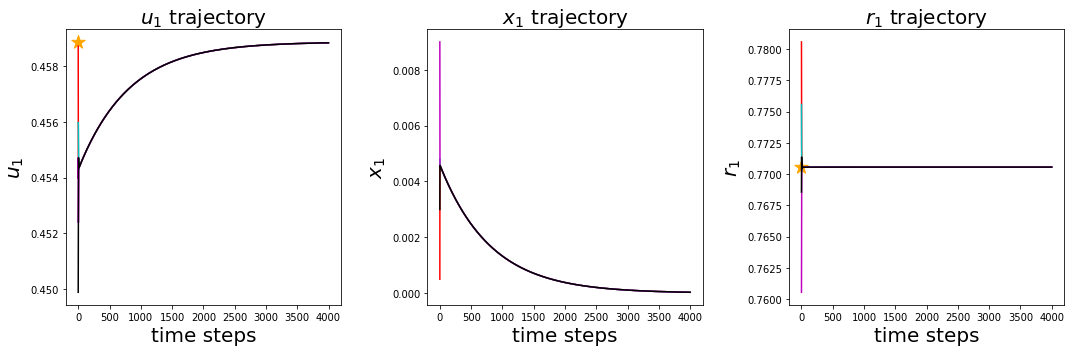

In [140]:
fig_small = plot_trajectories(mu,s,beta,0.01,tsteps=12)
fig_big = plot_trajectories(mu,s,beta,0.01,tsteps=4000)
#plot_trajectories(mu,s,beta,0.01,tsteps=10000)

In [120]:
# show u1, x1, r1 figures
uvec = [0.49,0.49,0.02]
rvec = [0.3, 0.8]
dumat,xmat,drmat = Perturb(uvec,rvec) # the columns of, for example dumat, correspond to u1, u2, bu.
# Progress: checked perturb and perturb edge case. working on get_init_pts

In [121]:
mu = 0
s = 1 
beta = 0.5
u1,df_init = get_init_pts(mu,s,beta)

In [123]:
np.vstack([df_init,df_init])

array([[0.00000000e+00, 6.82689492e-01, 1.58655254e-01, 1.00000000e+00,
        5.00000000e-01, 4.58730874e-01, 4.57780874e-01, 7.34882518e-02,
        7.80559563e-01, 7.79559563e-01, 5.00000000e-04, 1.00000000e-03,
        8.50000000e-03, 4.58880874e-01, 4.58880874e-01, 8.22382518e-02,
        7.70559563e-01, 7.70559563e-01, 1.92921482e+00],
       [0.00000000e+00, 6.82689492e-01, 1.58655254e-01, 1.00000000e+00,
        5.00000000e-01, 4.55980874e-01, 4.53980874e-01, 8.00382518e-02,
        7.75559563e-01, 7.67559563e-01, 4.80000000e-03, 5.00000000e-03,
        2.00000000e-04, 4.58880874e-01, 4.58880874e-01, 8.22382518e-02,
        7.70559563e-01, 7.70559563e-01, 1.92921482e+00],
       [0.00000000e+00, 6.82689492e-01, 1.58655254e-01, 1.00000000e+00,
        5.00000000e-01, 4.53980874e-01, 4.53780874e-01, 8.22382518e-02,
        7.60559563e-01, 7.80459563e-01, 9.00000000e-03, 4.00000000e-04,
        6.00000000e-04, 4.58880874e-01, 4.58880874e-01, 8.22382518e-02,
        7.70559563e-01

In [42]:
grad_s, stability = ExternalStability(beta,s,mu)

In [43]:
grad_s

-0.12542445890477338

In [45]:
u1

0.45888087408859657

In [46]:
row = df_init.head(1)
get_trajectory_external(row,ds=-0.01,color = "black",tsteps = 100)

,u1,u2,bu,x1,x2,bx,r1,r2,W,tstep,color,ds
0,0.4587,0.4578,0.0735,0.0005,0.0010,0.0085,0.7806,0.7796,1.9292,0,black,-0.0100
1,0.4548,0.4542,0.0810,0.0046,0.0046,0.0008,0.7761,0.7756,1.9387,1,black,-0.0100
2,0.4546,0.4541,0.0812,0.0046,0.0046,0.0008,0.7736,0.7734,1.9345,2,black,-0.0100
3,0.4545,0.4541,0.0813,0.0046,0.0046,0.0008,0.7722,0.7722,1.9322,3,black,-0.0100
4,0.4544,0.4542,0.0813,0.0046,0.0046,0.0008,0.7714,0.7715,1.9309,4,black,-0.0100
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.4537,0.4537,0.0813,0.0052,0.0052,0.0009,0.7706,0.7706,1.9292,95,black,-0.0100
96,0.4537,0.4537,0.0813,0.0052,0.0052,0.0009,0.7706,0.7706,1.9292,96,black,-0.0100
97,0.4537,0.4537,0.0813,0.0052,0.0052,0.0009,0.7706,0.7706,1.9292,97,black,-0.0100
98,0.4537,0.4537,0.0813,0.0052,0.0052,0.0009,0.7706,0.7706,1.9292,98,black,-0.0100


In [47]:
u1

0.45888087408859657